In [1]:
import numpy as np
from PIL import Image
import subprocess
import torch
from torch import nn
import torch.nn.functional as nf
import torchvision.transforms as transforms
from torchvision.models.resnet import resnet18
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import glob
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import csv
from sklearn.manifold import TSNE
from data import MyDataset

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
RANDOM_STATE_TSNE = 20

SOURCE_MODEL_FILE = './model1/resnet18_model.pth' # consistent with 
TARGET_MODEL_FILE = './output_DA/adda_target_weights.pth'
train_path = './train/' # 3*60 simulated imgs copied from <https://github.com/Jcq242818/CASTER/tree/retraining2/model1/train>
test_path = './test/' # 3*40 real test imgs copied from <https://github.com/Jcq242818/CASTER/tree/retraining2/model1/test>
train_txt_path = './train/train.txt'
test_txt_path = './test/test.txt'
output_path = './output_DA_2'
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_all = {}
test_all = {}
for trainable in [True,False]:
    if trainable:
        for category in ['pic1','pic2','pic3']:
            train_all[category] = glob.glob(os.path.join(train_path + category,'*.jpg'))   #这种写法是分了两个文件夹
            # print(os.path.join(train_path + category,'*.jpg'))
    else:
        for category in ['pic1','pic2','pic3']:
            test_all[category] = glob.glob(os.path.join(test_path + category,'*.jpg'))

train_paths = train_all['pic1'] + train_all['pic2'] + train_all['pic3']
m_list, s_list = [],[]
print('Read pic: \n')
for path in tqdm(train_paths):  #tqdm进度条模式，挺有意思的
    img = cv2.imread(path)
    img = img / 255.0
    m,s = cv2.meanStdDev(img)
    m_list.append(m.reshape((3,)))
    s_list.append(s.reshape((3,)))
m_array = np.array(m_list)
s_array = np.array(s_list)
m = m_array.mean(axis = 0, keepdims = True)
s = s_array.mean(axis = 0, keepdims = True)
normMean = m[0][::-1].copy()
normStd = s[0][::-1].copy()
normTransform = transforms.Normalize(normMean,normStd)
testTransform = transforms.Compose([
    transforms.ToTensor(),
    normTransform,
])

test_data = MyDataset(txt_path=test_txt_path,transform = testTransform)
test_loader = DataLoader(dataset = test_data,batch_size = batch_size)

Read pic: 



100%|██████████| 180/180 [00:00<00:00, 5550.39it/s]


In [4]:
from models import fc_part

target_model = resnet18(pretrained=True).to(device)
target_model.fc = fc_part().to(device)
target_model.load_state_dict(torch.load(TARGET_MODEL_FILE))
# print(target_model)

source_model = resnet18(pretrained=True).to(device)
source_model.fc = fc_part().to(device)
source_model.load_state_dict(torch.load(SOURCE_MODEL_FILE))

/home/lasso/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lasso/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [5]:
from utils import feature_extractor_resnet18

def predict_gesture(model,test_loader,device):
    predicted_list,labels_list = [],[]
    test_loss = 0.0
    test_correct = 0.0
    test_total = 0.0
    all_features = []
    with torch.no_grad():
        model.eval()
        with tqdm(test_loader,desc = 'Test') as t:
            for data in t :
                inputs ,labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                features = feature_extractor_resnet18(model,inputs)
                all_features.append(features.cpu().numpy())
                outputs = model.forward(inputs)
                # outputs2 = model.fc(features)
                # print(torch.equal(outputs,outputs2))
                l = nf.cross_entropy(outputs,labels)
                test_loss += l.item()
                _,predicted = torch.max(outputs,axis = 1)
                predicted_list.append(predicted)
                labels_list.append(labels)
                test_total += labels.size(0)
                test_correct += torch.sum(predicted == labels).item()
                # print(labels,'\n',predicted)
    test_acc = test_correct/test_total
    print("Accuracy: {}".format(test_acc))
    # 打开一个.csv文件进行写入
    with open(output_path + '/test_acc_alone.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        row = [1, test_acc]
        writer.writerow(row)
    predicted_list=[aa.tolist() for aa in predicted_list]
    pred_list_total = [i for item in predicted_list for i in item]
    labels_list=[aa.tolist() for aa in labels_list]
    labels_list_total = [i for item in labels_list for i in item]
    all_features = np.concatenate(all_features, axis=0)
    
    return labels_list_total, pred_list_total, all_features

## TSNE for test set

Test: 100%|██████████| 8/8 [00:02<00:00,  3.81it/s]


Accuracy: 0.9416666666666667
Normalized confusion matrix
[[0.95 0.   0.05]
 [0.   0.95 0.05]
 [0.   0.08 0.92]]


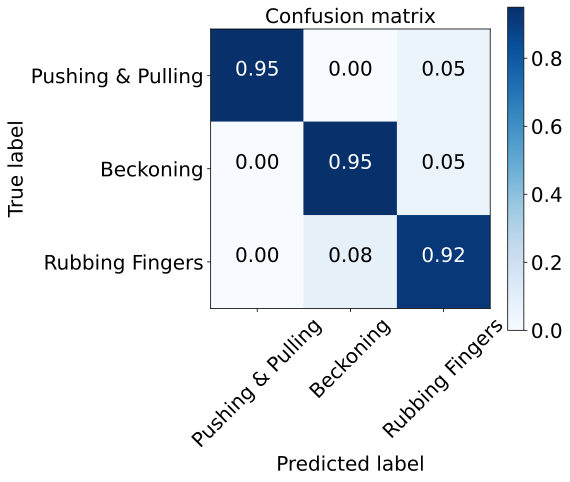

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


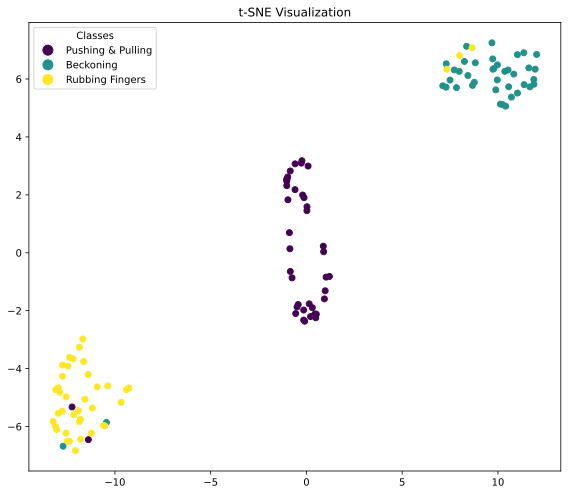

In [6]:
from utils import plot_confusion_matrix, plot_tsne

labels_list_total_test, pred_list_total_test, all_features_test = predict_gesture(target_model,test_loader,device)
plot_confusion_matrix(labels=labels_list_total_test,pre=pred_list_total_test,classes=['Pushing & Pulling','Beckoning','Rubbing Fingers'],savepath=output_path+'/Test_ConfMatrix',normalize=True)
tsne = TSNE(n_components=2, init='pca', random_state=RANDOM_STATE_TSNE)
tsne_result_test = tsne.fit_transform(all_features_test)
plot_tsne(tsne_result_test, labels_list_total_test, classes=['Pushing & Pulling','Beckoning','Rubbing Fingers'], savepath=output_path+'/Test_TSNE')

## TSNE for whole simulated dataset and real dataset

In [7]:
sim_path = './simulated_data/'
real_path = './real_data/'
sim_txt_path = './simulated_data/sim.txt'
real_txt_path= './real_data/real.txt'
sim_all = {}
real_all = {}
for is_sim in [True,False]:
    if is_sim:
        for category in ['pic1','pic2','pic3']:
            sim_all[category] = glob.glob(os.path.join(sim_path + category,'*.jpg'))
    else:
        for category in ['pic1','pic2','pic3']:
            real_all[category] = glob.glob(os.path.join(real_path + category,'*.jpg'))
mapkey = {
    'pic1' : '0',
    'pic2' : '1',
    'pic3' : '2',
}
def gen_txt(txt_path, img_paths):
    f = open(txt_path,'w')
    for key in img_paths.keys():
        label = mapkey[key]
        for path in img_paths[key]:
            line = path + ' ' + label +'\n'
            f.write(line)
gen_txt(sim_txt_path,sim_all)
gen_txt(real_txt_path,real_all)
sim_data = MyDataset(txt_path=sim_txt_path,transform = testTransform)
sim_loader = DataLoader(dataset = sim_data,batch_size = batch_size)
real_data = MyDataset(txt_path=real_txt_path,transform = testTransform)
real_loader = DataLoader(dataset = real_data,batch_size = batch_size)

labels_list_total_sim, pred_list_total_sim, all_features_sim = predict_gesture(source_model,sim_loader,device)
labels_list_total_real, pred_list_total_real, all_features_real = predict_gesture(target_model,real_loader,device)

Test: 100%|██████████| 19/19 [00:00<00:00, 57.45it/s]


Accuracy: 1.0


Test: 100%|██████████| 19/19 [00:00<00:00, 64.56it/s]

Accuracy: 0.91


In [8]:
# plot_confusion_matrix(labels=labels_list_total_sim,pre=pred_list_total_sim,classes=['Pushing & Pulling','Beckoning','Rubbing Fingers'],normalize=True)

In [9]:
# plot_confusion_matrix(labels=labels_list_total_real,pre=pred_list_total_real,classes=['Pushing & Pulling','Beckoning','Rubbing Fingers'],normalize=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


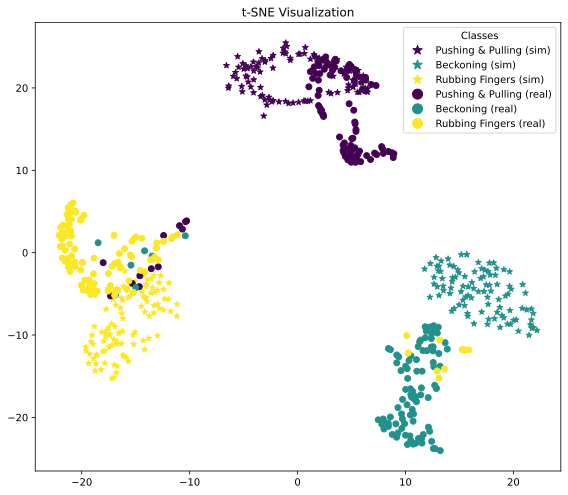

In [10]:
from utils import plot_tsne_v2

tsne = TSNE(n_components=2, init='pca', random_state=RANDOM_STATE_TSNE)
tsne_result_sim = tsne.fit_transform(all_features_sim)
tsne_result_real = tsne.fit_transform(all_features_real)
plot_tsne_v2(tsne_result_sim,labels_list_total_sim,tsne_result_real,labels_list_total_real,classes=['Pushing & Pulling','Beckoning','Rubbing Fingers'],savepath=output_path+'/ALL_TSNE',legend=True)